In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import squarify
import networkx as nx

## Functions

### Extract ID

In [73]:
def extract_id_from_url(url):
    if pd.isna(url) or not isinstance(url, str):
        return None
    try:
        # Remove any query parameters or fragments
        clean_url = url.split('?')[0].split('#')[0]
        # Extract the last part of the URL and convert to int
        return int(clean_url.rstrip('/').split('/')[-1])
    except (ValueError, AttributeError, IndexError):
        return None

In [113]:
def build_connections_dataframe(dfObservations, dfAnimals):
    # Filter observations to only include valid eater records
    eater_obs = dfObservations[
        (dfObservations['eater'] == 'eater') & 
        dfObservations['partner_id'].notna()
    ].copy()

    # Merge with dfAnimals to get details
    eater_merged = pd.merge(
        eater_obs,
        dfAnimals,
        left_on='scientific_name',
        right_on='scientific_name',
        how='inner'
    )

    # Rename columns
    eater_merged = eater_merged.rename(columns={
        'id_x': 'observation_id',
        'id_y': 'eater_id',
        'scientific_name': 'eater_scientific_name',
        'common_name_x': 'eater_common_name',
        'iconic_taxon_name_x': 'eater_category'
    })

    # Dropping columns
    eater_merged = eater_merged.drop(columns=[
        'species_guess',
        'time_observed_at',
        'partner',
        'common_name_y',
        'iconic_taxon_name_y',
        'scientific_name_lower',
        'eater'
    ])

    # Get eaten observations
    eaten_obs = dfObservationsT[['id', 'scientific_name']].rename(columns={
        'id': 'partner_id',
        'scientific_name': 'eaten_scientific_name'
    })

    # Merge to get eaten details
    eater_merged = pd.merge(
        eater_merged,
        eaten_obs,
        on='partner_id',
        how='inner'
    )

    # Merge with dfAnimals to get eaten animal details
    eater_merged = pd.merge(
        eater_merged,
        dfAnimals.rename(columns={
            'scientific_name': 'eaten_scientific_name',
            'id': 'eaten_id',
            'common_name': 'eaten_common_name',
            'iconic_taxon_name': 'eaten_category'
        }),
        on='eaten_scientific_name',
        how='left'
    )

    # Calculate frequency of each connection
    eater_merged['frequency'] = 1
    eater_merged = eater_merged.groupby([
        'observation_id',
        'eater_id',
        'eater_scientific_name',
        'eater_common_name',
        'eater_category',
        'eaten_id',
        'eaten_scientific_name',
        'eaten_common_name',
        'eaten_category'
    ])['frequency'].sum().reset_index()

    eater_merged['eaten_id'] = eater_merged['eaten_id'].astype('Int64')

    # Select and order final columns
    final_connections = eater_merged[[
        'observation_id',
        'eater_id',
        'eater_scientific_name',
        'eater_common_name',
        'eater_category',
        'eaten_id',
        'eaten_scientific_name',
        'eaten_common_name',
        'eaten_category',
        'frequency'
    ]]

    return final_connections

## Data Loading

In [50]:
dfObservations = pd.read_csv("data/observations.csv")
dfAnimalTraits = pd.read_csv("data/animal-traits.csv")

In [4]:
dfObservations.head()

,id,uuid,observed_on_string,observed_on,time_observed_at,time_zone,user_id,user_login,user_name,created_at,...,geoprivacy,positioning_device,species_guess,scientific_name,common_name,iconic_taxon_name,taxon_id,"field:id meant for ""eater"" or organism being eaten?","field:url for ""partner"" observation",field:is observation one of these special types of feeding?
0,10686,6662b18b-6343-460b-90e8-d494df9766e8,2006-07-01,2006-07-01,NaN,Eastern Time (US & Canada),520,johnnybirder,Johnny Wilson,2011-01-30 08:03:49 -0700,...,NaN,NaN,House Mouse,Mus musculus,House Mouse,Mammalia,44705,eater,https://www.inaturalist.org/observations/1766953,"No, none of these"
1,338604,c127ae38-c311-40bb-bc5f-2e48d8e02c59,2012-08-19 8:00 AM,2012-08-19,2012-08-19 07:00:00 -0600,Central Time (US & Canada),17056,fvaldesp_tutor,Francisco Valdes Perezgasga,2013-07-19 16:24:55 -0600,...,NaN,NaN,Correcaminos norteño,Geococcyx californianus,Greater Roadrunner,Aves,1986,eater,NaN,"No, none of these"
2,414645,8900f5f2-3c54-4397-b215-7033ab0c0e4b,1988-07-13,1988-07-13,NaN,Harare,23072,i_c_riddell,NaN,2013-10-02 02:14:16 -0600,...,NaN,NaN,Cape Wolf Snake,Lycophidion capense,Cape Wolf Snake,Reptilia,29508,eater,https://www.inaturalist.org/observations/414707,NaN
3,414707,f71bf6a5-7cc2-49c3-b5dd-df5716f5cb32,1988-07-13,1988-07-13,NaN,Harare,23072,i_c_riddell,NaN,2013-10-02 02:47:17 -0600,...,NaN,NaN,Sundevall's Writhing Skink,Mochlus sundevallii,Sundevall's Writhing Skink,Reptilia,37932,thing being eaten,https://www.inaturalist.org/observations/414645,NaN
4,420386,56bf357d-9c01-4e0a-8cdb-a4f7aa548081,2013-10-06 15:10:40,2013-10-06,2013-10-06 13:10:40 -0600,Eastern Time (US & Canada),12796,scadwell,Suzanne Cadwell,2013-10-06 16:55:37 -0600,...,NaN,manual,Eastern Kingsnake,Lampropeltis getula,Eastern Kingsnake,Reptilia,29813,NaN,NaN,NaN


In [37]:
dfAnimalTraits.head()

,phylum,class,order,family,genus,species,specificEpithet,sex,sampleSizeValue,inTextReference,...,mass-specific metabolic rate - units,brain size,brain size - units,brain size - minimum,brain size - maximum,brain size - method,brain size - comments,brain size - metadata comment,original brain size,original brain size - units
0,Chordata,Amphibia,Anura,Hylidae,Hyla,Hyla versicolor,versicolor,NaN,1,"Taylor, Nol, & Boire, 1995",...,NaN,0.000042,kg,NaN,NaN,histological reconstruction,total brain volume,photographs of cross sections were taken and v...,40.79,mm3
1,Chordata,Amphibia,Anura,Hylidae,Pseudacris,Pseudacris triseriata,triseriata,NaN,3,"Taylor, Nol, & Boire, 1995",...,NaN,0.000002,kg,NaN,NaN,histological reconstruction,NaN,photographs of cross sections were taken and v...,2.18,mm3
2,Chordata,Amphibia,Anura,Hylidae,Acris,Acris crepitans,crepitans,NaN,3,"Taylor, Nol, & Boire, 1995",...,NaN,0.000004,kg,NaN,NaN,histological reconstruction,NaN,photographs of cross sections were taken and v...,4.28,mm3
3,Chordata,Amphibia,Anura,Ceratobatrachidae,Platymantis,Platymantis vitiensis,vitiensis,NaN,1,"Taylor, Nol, & Boire, 1995",...,NaN,0.000005,kg,NaN,NaN,histological reconstruction,NaN,photographs of cross sections were taken and v...,4.76,mm3
4,Chordata,Amphibia,Anura,Ranidae,Rana,Rana sylvatica,sylvatica,NaN,3,"Taylor, Nol, & Boire, 1995",...,NaN,0.000009,kg,NaN,NaN,histological reconstruction,NaN,photographs of cross sections were taken and v...,8.27,mm3


## Exploration

### Observations

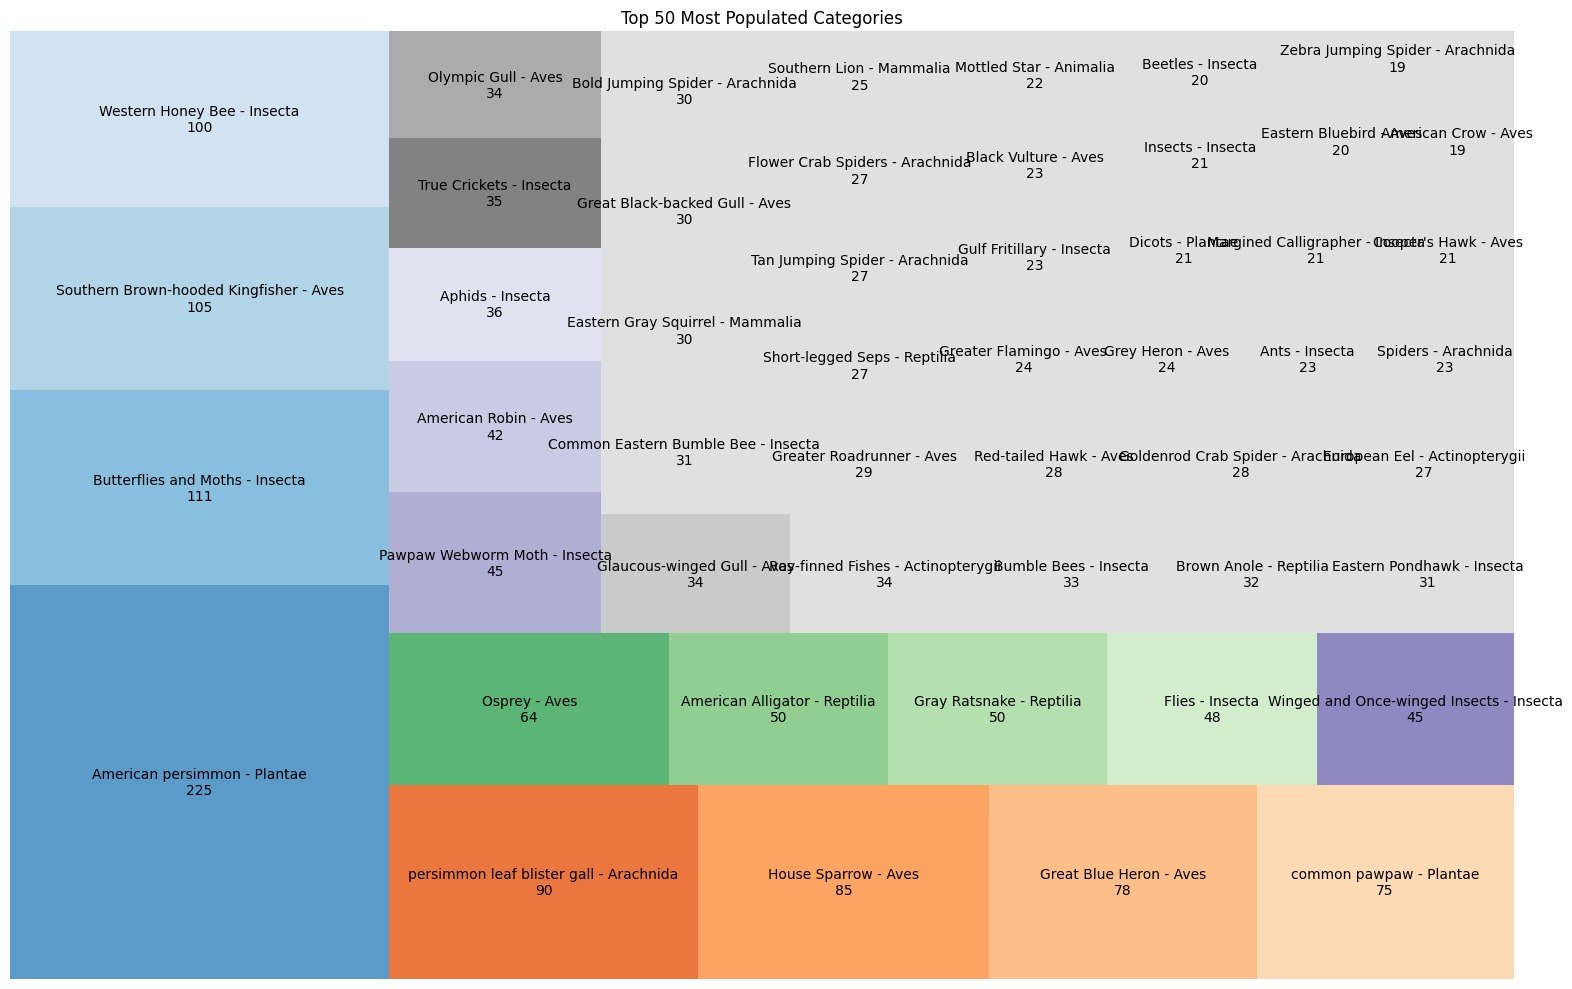

In [35]:
# Create a count of records for each combination
counts = dfObservations.groupby(['common_name', 'iconic_taxon_name']).size().reset_index(name='count')

# Sort by count in descending order and take top 50
top_50 = counts.sort_values('count', ascending=False).head(50)

# Create labels for the treemap
labels = [f"{cat1} - {cat2}\n{count}" for cat1, cat2, count in top_50.values]

# Create the treemap
plt.figure(figsize=(16, 10))
squarify.plot(sizes=top_50['count'], 
              label=labels,
              alpha=0.8,
              color=plt.cm.tab20c(range(len(top_50))))

plt.axis('off')
plt.title('Top 50 Most Populated Categories')
plt.tight_layout()
plt.show()

In [41]:
# Add the new column with extracted IDs
df_filtered['partner_id'] = df_filtered['partner_observation_url'].apply(extract_id)

# Convert to numeric, setting errors='coerce' to convert non-numeric values to NaN
df_filtered['partner_id'] = pd.to_numeric(df_filtered['partner_id'], errors='coerce')

# Convert to nullable integer type (Int64) which can handle NA values
df_filtered['partner_id'] = df_filtered['partner_id'].astype('Int64')  # Note: Capital 'I' in 'Int64'

df_filtered.head()

,id,time_observed_at,common_name,scientific_name,iconic_taxon_name,interaction_role,partner_observation_url,partner_id
0,10686,NaN,House Mouse,Mus musculus,Mammalia,eater,https://www.inaturalist.org/observations/1766953,1766953
1,338604,2012-08-19 07:00:00 -0600,Greater Roadrunner,Geococcyx californianus,Aves,eater,NaN,<NA>
2,414645,NaN,Cape Wolf Snake,Lycophidion capense,Reptilia,eater,https://www.inaturalist.org/observations/414707,414707
3,414707,NaN,Sundevall's Writhing Skink,Mochlus sundevallii,Reptilia,thing being eaten,https://www.inaturalist.org/observations/414645,414645
4,420386,2013-10-06 13:10:40 -0600,Eastern Kingsnake,Lampropeltis getula,Reptilia,NaN,NaN,<NA>


In [43]:
# Check if 'species' has all unique values
is_unique = dfAnimalTraits['species'].nunique() == len(dfAnimalTraits)
print(f"Column has all unique values: {is_unique}")

# To see the number of unique values vs total rows
print(f"Unique values: {dfAnimalTraits['species'].nunique()}")
print(f"Total rows: {len(dfAnimalTraits)}")

Column has all unique values: False
Unique values: 2032
Total rows: 3580


### Animal traits

In [44]:
# Count occurrences of each value in 'species' and get top 5
top_5 = dfAnimalTraits['species'].value_counts().head(5)
print("Top 5 most common values and their counts:")
print(top_5)

# If you want to include percentages
value_counts = dfAnimalTraits['species'].value_counts(normalize=True).mul(100).round(2)
top_5_with_percent = pd.DataFrame({
    'count': dfAnimalTraits['species'].value_counts().head(5),
    'percentage': value_counts.head(5)
})
print("\nTop 5 with percentages:")
print(top_5_with_percent)

Top 5 most common values and their counts:
species
Oecophylla smaragdina    67
Cephalotes varians       60
Camponotus maculatus     50
Messor capensis          49
Bombus impatiens         47
Name: count, dtype: int64

Top 5 with percentages:
                       count  percentage
species                                 
Oecophylla smaragdina     67        1.87
Cephalotes varians        60        1.68
Camponotus maculatus      50        1.40
Messor capensis           49        1.37
Bombus impatiens          47        1.31


## Data Transformation

### Animal Traits

In [53]:
dfAnimalTraitsT = dfAnimalTraits.copy()
dfAnimalTraitsT = dfAnimalTraitsT[["family", "genus", "species", "body mass", "body mass - units", "brain size", "brain size - units"]]
dfAnimalTraitsT = dfAnimalTraitsT[dfAnimalTraitsT['body mass - units'] == 'kg']
dfAnimalTraitsT = dfAnimalTraitsT[dfAnimalTraitsT['brain size - units'] == 'kg']

dfAnimalTraitsT = dfAnimalTraitsT.drop(columns=["body mass - units", "brain size - units"])

dfAnimalTraitsT["body mass"] = dfAnimalTraitsT["body mass"] * 1000
dfAnimalTraitsT["brain size"] = dfAnimalTraitsT["brain size"] * 1000


dfAnimalTraitsT.head()

,family,genus,species,body mass,brain size
0,Hylidae,Hyla,Hyla versicolor,13.15,0.042258
1,Hylidae,Pseudacris,Pseudacris triseriata,0.10,0.002258
2,Hylidae,Acris,Acris crepitans,0.30,0.004434
3,Ceratobatrachidae,Platymantis,Platymantis vitiensis,0.30,0.004931
4,Ranidae,Rana,Rana sylvatica,0.37,0.008568


In [55]:
dfAggregated = dfAnimalTraitsT.groupby(['family', 'genus', 'species'])[['body mass', 'brain size']].mean().reset_index()
dfAggregated.head()

,family,genus,species,body mass,brain size
0,Acanthizidae,Acanthiza,Acanthiza chrysorrhoa,9.1,0.44548
1,Acanthizidae,Acanthiza,Acanthiza ewingii,7.0,0.65268
2,Acanthizidae,Acanthiza,Acanthiza inornata,7.0,0.45584
3,Acanthizidae,Acanthiza,Acanthiza lineata,7.3,0.52836
4,Acanthizidae,Acanthiza,Acanthiza nana,6.5,0.37296


In [57]:
unique_species = dfAggregated['species'].unique()
top5 = dfAggregated['species'].value_counts().head(5)

dfAggregated[dfAggregated['species'] == 'Saguinus oedipus'].head()

,family,genus,species,body mass,brain size
176,Callitrichidae,Saguinus,Saguinus oedipus,370.00,9.45
212,Cebidae,Saguinus,Saguinus oedipus,327.14,9.64


### Observations

#### Preprocessing

In [86]:
dfObservationsT = dfObservations.copy()
columns = [
    'id',
    'species_guess',
    'scientific_name',
    'common_name',
    'iconic_taxon_name',
    'time_observed_at',
    'field:id meant for "eater" or organism being eaten?',	
    'field:url for "partner" observation'
]

dfObservationsT = dfObservationsT[columns]
dfObservationsT = dfObservationsT.rename(columns={
    'field:id meant for "eater" or organism being eaten?': 'eater',
    'field:url for "partner" observation': 'partner',
})

# Apply the function to create a new column 'partner_id'
dfObservationsT['partner_id'] = dfObservationsT['partner'].apply(extract_id_from_url)

# Convert to Int64 type which supports NA values
dfObservationsT['partner_id'] = dfObservationsT['partner_id'].astype('Int64')


dfObservationsT.head()

,id,species_guess,scientific_name,common_name,iconic_taxon_name,time_observed_at,eater,partner,partner_id
0,10686,House Mouse,Mus musculus,House Mouse,Mammalia,NaN,eater,https://www.inaturalist.org/observations/1766953,1766953
1,338604,Correcaminos norteño,Geococcyx californianus,Greater Roadrunner,Aves,2012-08-19 07:00:00 -0600,eater,NaN,<NA>
2,414645,Cape Wolf Snake,Lycophidion capense,Cape Wolf Snake,Reptilia,NaN,eater,https://www.inaturalist.org/observations/414707,414707
3,414707,Sundevall's Writhing Skink,Mochlus sundevallii,Sundevall's Writhing Skink,Reptilia,NaN,thing being eaten,https://www.inaturalist.org/observations/414645,414645
4,420386,Eastern Kingsnake,Lampropeltis getula,Eastern Kingsnake,Reptilia,2013-10-06 13:10:40 -0600,NaN,NaN,<NA>


#### Animals dataframe

In [125]:
# Group by scientific_name and take the first occurrence of other columns
dfAnimals = dfObservationsT.groupby('scientific_name', as_index=False).agg({
    'common_name': 'first',
    'iconic_taxon_name': 'first'
}).reset_index(drop=True)

# Create an ID column from the scientific_name (you can use different encoding if needed)
dfAnimals['id'] = dfAnimals['scientific_name'].astype('category').cat.codes + 1

# Reorder columns to have id first
dfAnimals = dfAnimals[['id', 'scientific_name', 'common_name', 'iconic_taxon_name']]

# Save to a CSV file
dfAnimals.to_csv('animals.csv', index=False)

# Display the result
dfAnimals.head()

,id,scientific_name,common_name,iconic_taxon_name
0,1,Abantennarius sanguineus,Bloody Frogfish,Actinopterygii
1,2,Abantis paradisea,Paradise Skipper,Insecta
2,3,Abbottina rivularis,Chinese False Gudgeon,Actinopterygii
3,4,Abisares viridipennis,Notched Shield Grasshopper,Insecta
4,5,Abramis brama,Common Bream,Actinopterygii


#### Network dataframe

In [114]:
dfConnections = build_connections_dataframe(dfObservations = dfObservationsT, dfAnimals = dfAnimals)
dfConnections.head()

,observation_id,eater_id,eater_scientific_name,eater_common_name,eater_category,eaten_id,eaten_scientific_name,eaten_common_name,eaten_category,frequency
0,10686,3037,Mus musculus,House Mouse,Mammalia,3415,Pachyptila vittata,Broad-billed Prion,Aves,1
1,414645,2748,Lycophidion capense,Cape Wolf Snake,Reptilia,3003,Mochlus sundevallii,Sundevall's Writhing Skink,Reptilia,1
2,465679,2735,Lutra capensis capensis,Cape Clawless Otter,Mammalia,72,Actinopterygii,Ray-finned Fishes,Actinopterygii,1
3,509046,1473,Dendroaspis polylepis,Black Mamba,Reptilia,3803,Ploceus cucullatus,Village Weaver,Aves,1
4,518909,1031,Chamaeleo namaquensis,Namaqua Chameleon,Reptilia,4684,Tenebrionidae,Darkling Beetles,Insecta,1


#### Building directed graph

In [121]:
# Create a directed graph
G = nx.DiGraph()

# Add nodes with attributes
for _, row in dfAnimals.iterrows():
    G.add_node(
        row['id'],
        scientific_name=row['scientific_name'],
        common_name=row['common_name'],
        category=row['iconic_taxon_name']
    )

# Add edges with weight from frequency
for _, row in final_connections.iterrows():
    if pd.notna(row['eaten_id']):  # Only add edges where eaten_id is not null
        G.add_edge(
            row['eater_id'],
            int(row['eaten_id']),  # Convert to int to remove .0
            weight=row['frequency']
        )
        
# First, clean the graph data
for node, data in G.nodes(data=True):
    for key, value in list(data.items()):
        if value is None:
            data[key] = ""  # Replace None with empty string
            # Alternatively, you could remove the attribute:
            # del data[key]

# Also clean edge attributes
for u, v, data in G.edges(data=True):
    for key, value in list(data.items()):
        if value is None:
            data[key] = ""  # Replace None with empty string
            # Or remove the attribute:
            # del data[key]
# Write network
nx.write_gexf(G, 'animal_graph.gexf', encoding='utf-8', prettyprint=True)

# Basic network statistics
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print(f"Average in-degree: {sum(dict(G.in_degree()).values()) / G.number_of_nodes():.2f}")
print(f"Average out-degree: {sum(dict(G.out_degree()).values()) / G.number_of_nodes():.2f}")


Number of nodes: 5159
Number of edges: 2906
Average in-degree: 0.56
Average out-degree: 0.56


### Combine Observations and Traits

In [89]:
# Convert both join keys to the same case (e.g., lowercase) before joining
dfAnimals['scientific_name_lower'] = dfAnimals['scientific_name'].str.lower()
dfAggregated['species_lower'] = dfAggregated['species'].str.lower()

result_df = pd.merge(
    dfAnimals,
    dfAggregated,
    left_on='scientific_name_lower',
    right_on='species_lower',
    how='left'
)

# Remove the temporary lowercase columns
result_df = result_df.drop(columns=['scientific_name_lower', 'species_lower'])
result_df.head()

,id,scientific_name,common_name,iconic_taxon_name,family,genus,species,body mass,brain size
0,1,Abantennarius sanguineus,Bloody Frogfish,Actinopterygii,NaN,NaN,NaN,NaN,NaN
1,2,Abantis paradisea,Paradise Skipper,Insecta,NaN,NaN,NaN,NaN,NaN
2,3,Abbottina rivularis,Chinese False Gudgeon,Actinopterygii,NaN,NaN,NaN,NaN,NaN
3,4,Abisares viridipennis,Notched Shield Grasshopper,Insecta,NaN,NaN,NaN,NaN,NaN
4,5,Abramis brama,Common Bream,Actinopterygii,NaN,NaN,NaN,NaN,NaN


In [90]:
# Count total records in the result
total_records = len(result_df)

# Count records with matching data from dfAggregated
matched_records = result_df[result_df['species'].notna()].shape[0]

# Calculate the percentage matched
match_percentage = (matched_records / total_records) * 100

print(f"Total records in dfAnimals: {total_records}")
print(f"Records with matching data from dfAggregated: {matched_records}")
print(f"Percentage matched: {match_percentage:.2f}%")

# Optional: Show a sample of non-matched records
non_matched = result_df[result_df['species'].isna()]
if not non_matched.empty:
    print("\nSample of non-matched scientific_names:")
    print(non_matched[['scientific_name']].head())

Total records in dfAnimals: 5159
Records with matching data from dfAggregated: 118
Percentage matched: 2.29%

Sample of non-matched scientific_names:
            scientific_name
0  Abantennarius sanguineus
1         Abantis paradisea
2       Abbottina rivularis
3     Abisares viridipennis
4             Abramis brama


In [95]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import pandas as pd

# Filtrar registros sin coincidencia
no_matches = result_df[result_df['species'].isna()].copy()

# Obtener lista de nombres científicos únicos del otro dataframe
matching_names = dfAggregated['species'].dropna().unique().tolist()

def find_best_match(row):
    # Buscar la mejor coincidencia
    match = process.extractOne(
        row['scientific_name'], 
        matching_names,
        scorer=fuzz.token_sort_ratio  # Usa token sort para mejor manejo de orden de palabras
    )
    if match:
        return pd.Series([match[0], match[1]])
    return pd.Series([None, None])

# Aplicar búsqueda de coincidencia solo a los registros sin match
no_matches[['best_match', 'similarity_score']] = no_matches.apply(find_best_match, axis=1)

# Mostrar resultados
print(f"Se encontraron {len(no_matches)} registros sin coincidencia exacta")
print("\nTop 10 mejores coincidencias encontradas:")
for _, row in no_matches.nlargest(10, 'similarity_score').iterrows():
    print(f"Original: {row['scientific_name']}")
    print(f"Mejor coincidencia: {row['best_match']}")
    print(f"Similitud: {row['similarity_score']}%")
    print("-" * 50)

# Si deseas actualizar el dataframe original con las coincidencias
# Primero crea un diccionario de mapeo
match_dict = dict(zip(no_matches['scientific_name'], no_matches['best_match']))
similarity_dict = dict(zip(no_matches['scientific_name'], no_matches['similarity_score']))

# Luego actualiza el dataframe original
result_df['best_match'] = result_df['scientific_name'].map(match_dict)
result_df['similarity_score'] = result_df['scientific_name'].map(similarity_dict)

# Opcional: Filtrar por un umbral de similitud
umbral_similitud = 70  # Ajusta según necesites
result_df['species'] = result_df.apply(
    lambda x: x['best_match'] if pd.isna(x['species']) and x['similarity_score'] >= umbral_similitud else x['species'],
    axis=1
)

# Mostrar estadísticas finales
total_corregidos = result_df['best_match'].notna().sum()
print(f"\nSe encontraron coincidencias para {total_corregidos} registros")
print(f"Coincidencias con similitud > {umbral_similitud}%: {len(result_df[result_df['similarity_score'] >= umbral_similitud])}")

Se encontraron 4982 registros sin coincidencia exacta

Top 10 mejores coincidencias encontradas:
Original: Accipiter nisus
Mejor coincidencia: Accipiter striatus
Similitud: 79%
--------------------------------------------------
Original: Anas platyrhynchos
Mejor coincidencia: Anas rhynchotis
Similitud: 79%
--------------------------------------------------
Original: Annona senegalensis
Mejor coincidencia: Galago senegalensis
Similitud: 79%
--------------------------------------------------
Original: Ardea cinerea cinerea
Mejor coincidencia: Ardea intermedia intermedia
Similitud: 79%
--------------------------------------------------
Original: Buteo lineatus
Mejor coincidencia: Buteo vulpinus
Similitud: 79%
--------------------------------------------------
Original: Caracal caracal caracal
Mejor coincidencia: Caracal caracal
Similitud: 79%
--------------------------------------------------
Original: Ciconia ciconia ciconia
Mejor coincidencia: Ciconia ciconia
Similitud: 79%
------------

In [101]:
# Write to csv
result_df['scientific_name'].to_csv("results.csv", index=False)

In [102]:
import pandas as pd
import requests
import time
import sys

def obtener_datos_animales(input_file='results.csv', output_file='animales_atributos_final.csv'):
    # 1. Cargar el CSV original
    try:
        df = pd.read_csv(input_file)
        # Asumimos que la columna se llama 'scientific_name' o 'Nombre_Cientifico'
        col_name = 'scientific_name' if 'scientific_name' in df.columns else df.columns[0]
        nombres = df[col_name].dropna().unique().tolist()
        print(f"Cargados {len(nombres)} nombres científicos únicos.")
    except Exception as e:
        print(f"Error al leer el archivo: {e}")
        return

    # Preparar listas para guardar resultados
    resultados = []
    
    # URL del servicio de consultas de Wikidata
    url = "https://query.wikidata.org/sparql"
    
    # Headers para identificar el script (buena práctica en Wikidata)
    headers = {
        'User-Agent': 'AnimalDataBot/1.0 (tu_email@ejemplo.com)'
    }

    # Procesar en lotes de 50 para no bloquear la consulta
    batch_size = 50
    total_batches = (len(nombres) + batch_size - 1) // batch_size

    print("Iniciando descarga de datos de Wikidata...")

    for i in range(0, len(nombres), batch_size):
        batch = nombres[i:i+batch_size]
        
        # Construir la lista de valores para la consulta SPARQL
        values_str = " ".join([f'"{n}"' for n in batch])
        
        # Consulta SPARQL: Busca nombre científico, peso, longitud y dieta
        query = f"""
        SELECT ?name ?itemLabel ?mass ?massUnitLabel ?length ?lengthUnitLabel ?dietLabel WHERE {{
          VALUES ?name {{ {values_str} }}
          ?item wdt:P225 ?name .
          
          # Intentar obtener peso (P2067)
          OPTIONAL {{ 
            ?item p:P2067/psn:P2067/wikibase:quantityAmount ?mass . 
            ?item p:P2067/psn:P2067/wikibase:quantityUnit ?massUnit .
          }}
          
          # Intentar obtener longitud (P2043) o altura (P2048)
          OPTIONAL {{ 
            ?item p:P2043/psn:P2043/wikibase:quantityAmount ?length . 
            ?item p:P2043/psn:P2043/wikibase:quantityUnit ?lengthUnit .
          }}
          
          # Intentar obtener dieta (P1034 - alimento principal)
          OPTIONAL {{ ?item wdt:P1034 ?diet . }}
          
          # Servicio de etiquetas para obtener nombres en Español (o Inglés si no hay)
          SERVICE wikibase:label {{ bd:serviceParam wikibase:language "es,en". }}
        }}
        """

        try:
            r = requests.get(url, params={'format': 'json', 'query': query}, headers=headers)
            data = r.json()
            
            for item in data['results']['bindings']:
                # Extraer datos con seguridad
                res = {
                    'Nombre_Cientifico': item.get('name', {}).get('value'),
                    'Nombre_Comun': item.get('itemLabel', {}).get('value'),
                    'Peso_Valor': item.get('mass', {}).get('value'),
                    'Peso_Unidad': item.get('massUnitLabel', {}).get('value'),
                    'Tamano_Valor': item.get('length', {}).get('value'),
                    'Tamano_Unidad': item.get('lengthUnitLabel', {}).get('value'),
                    'Dieta': item.get('dietLabel', {}).get('value')
                }
                resultados.append(res)
                
            # Pequeña pausa para ser amables con el servidor
            time.sleep(1)
            
            # Barra de progreso simple
            sys.stdout.write(f"\rProcesado lote {i//batch_size + 1}/{total_batches}")
            sys.stdout.flush()
            
        except Exception as e:
            print(f"\nError en el lote {i}: {e}")

    # Convertir a DataFrame y guardar
    df_final = pd.DataFrame(resultados)
    
    # Limpieza final: Eliminar duplicados que genera SPARQL si hay múltiples dietas
    df_final = df_final.drop_duplicates(subset=['Nombre_Cientifico'])
    
    df_final.to_csv(output_file, index=False)
    print(f"\n\n¡Listo! Archivo guardado como: {output_file}")
    print(df_final.head())

obtener_datos_animales()

Cargados 5159 nombres científicos únicos.
Iniciando descarga de datos de Wikidata...
Procesado lote 104/104

¡Listo! Archivo guardado como: animales_atributos_final.csv
       Nombre_Cientifico          Nombre_Comun Peso_Valor Peso_Unidad  \
0                  Acari                 Acari       None        None   
1        Accipiter nisus         gavilán común       0.29   kilogramo   
49  Achillea millefolium  Achillea millefolium       None        None   
50              Abutilon              Abutilon       None        None   
51       Acanthus mollis       Acanthus mollis       None        None   

   Tamano_Valor Tamano_Unidad    Dieta  
0          None          None     None  
1          None          None  insecto  
49         None          None     None  
50         None          None     None  
51         None          None     None  
